## Loading and Processing Dataset

In [1]:
# Import the mixed_precision package from TensorFlow
from tensorflow.keras.mixed_precision import set_global_policy

# Set the global policy to 'mixed_float16'
set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
from tensorflow.keras.backend import clear_session

# Define the paths to your image directories
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Define parameters
img_height, img_width = 160, 160
batch_size=16

In [4]:
# Create ImageDataGenerator instances
datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories using ImageDataGenerator
def load_images_from_directory(directory):
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=False
    )
    images = []
    labels = []
    for _ in range(len(generator)):
        img_batch, label_batch = next(generator)
        images.extend(img_batch)
        labels.extend(label_batch)
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_directory(train_dir)
val_images, val_labels = load_images_from_directory(val_dir)
test_images, test_labels = load_images_from_directory(test_dir)

print(f'Training images: {train_images.shape[0]}')
print(f'Validation images: {val_images.shape[0]}')
print(f'Test images: {test_images.shape[0]}')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training images: 5216
Validation images: 16
Test images: 624


In [5]:
# Combine all images and labels
all_images = np.concatenate((train_images, val_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, val_labels, test_labels), axis=0)

# Split the combined dataset into 80% training, 10% validation, and 10% test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)

print(f'Total images: {all_images.shape[0]}')
print(f'Training images: {train_images.shape[0]}')
print(f'Validation images: {val_images.shape[0]}')
print(f'Test images: {test_images.shape[0]}')


Total images: 5856
Training images: 4684
Validation images: 586
Test images: 586


In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Define the number of augmented samples you want to generate
augmentation_factor = 1

# Calculate the total number of augmented samples
total_augmented_samples = len(train_images) * augmentation_factor

# Initialize arrays to hold augmented data
augmented_images = np.zeros((total_augmented_samples, img_height, img_width, 1))
augmented_labels = np.zeros((total_augmented_samples,))

# Use the ImageDataGenerator to fill the arrays with augmented data
generated_samples = 0
for batch_images, batch_labels in train_datagen.flow(train_images, train_labels, batch_size=batch_size, shuffle=False):
    batch_size_effective = len(batch_images)
    if generated_samples + batch_size_effective > total_augmented_samples:
        # Avoid overshooting the array size
        batch_size_effective = total_augmented_samples - generated_samples
    
    augmented_images[generated_samples:generated_samples + batch_size_effective] = batch_images
    augmented_labels[generated_samples:generated_samples + batch_size_effective] = batch_labels
    
    generated_samples += batch_size_effective
    if generated_samples >= total_augmented_samples:
        break

# x_train and y_train are now your augmented datasets
x_train = augmented_images
y_train = augmented_labels

# x_val and y_val remain unchanged
x_val = val_images
y_val = val_labels

# x_test and y_test remain unchanged
x_test = test_images
y_test = test_labels

# Print the shapes to verify
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (4684, 160, 160, 1)
y_train shape: (4684,)
x_val shape: (586, 160, 160, 1)
y_val shape: (586,)
x_test shape: (586, 160, 160, 1)
y_test shape: (586,)


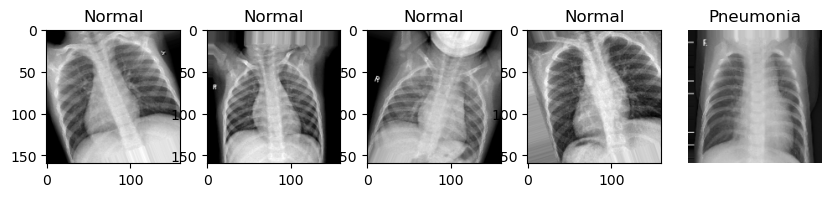

In [7]:
def plot_images(images, labels, num_images):
    plt.figure(figsize=(10, 10))
    
    # Randomly select indices
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)
    
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title('Normal' if labels[idx] == 0 else 'Pneumonia')
    
    plt.axis('off')
    
    plt.show()

# Example usage:
plot_images(x_train, y_train, 5)


# 1. Convolutional Neural Network Model Exploration

## 1.1 Developing CNN Model That Does Better Than a Baseline 

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [9]:
naive_baseline = 1 / 2  # Since there are 2 classes
print(f"Naive Baseline: {naive_baseline}")

Naive Baseline: 0.5


In [10]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall_value = true_positives / (possible_positives + K.epsilon())
        return recall_value

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision_value = true_positives / (predicted_positives + K.epsilon())
        return precision_value

    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_val = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1_val


In [11]:
learning_rate=0.001
LOSS_FUNC = 'binary_crossentropy'

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    f1_score,
    AUC(name='auc')
]

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=1)

In [12]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 'es')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

In [13]:
# Define the CNN model
basemodel = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 99856)             0         
                                                                 
 dense (Dense)               (None, 8)                 798856    
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 799,025
Trainable params: 799,025
Non-trainable params: 0
__________________________________________________

In [14]:
basemodel.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [15]:
# Train the model

basemodel_history = basemodel.fit(x_train, y_train,
                                    batch_size=16,
                                    epochs=100, 
                                    validation_data=(x_val, y_val), 
                                    callbacks=[EARLY_STOP],
                                    verbose=0)

Restoring model weights from the end of the best epoch: 10.
Epoch 15: early stopping


In [16]:
# Evaluate the model on the test set
results = basemodel.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.23027043044567108 - Accuracy: 0.9180887341499329 - Precision: 0.938725471496582 - Recall: 0.9433497786521912 - F1 Score: 0.9393734335899353 - AUC: 0.9641488790512085


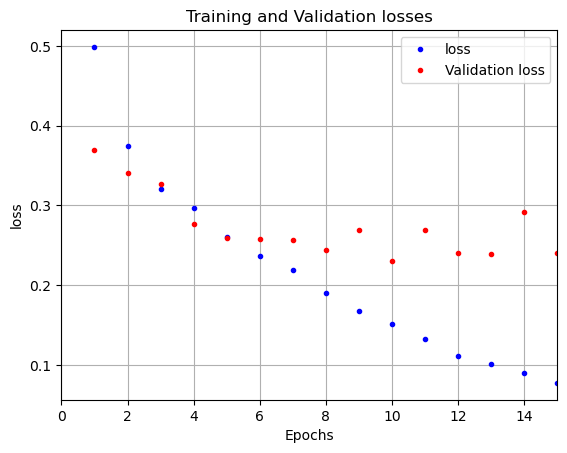

In [17]:
plot_training_history(basemodel_history, monitor='loss')

Results Review:
- Loss: 0.617
- Accuracy: 0.693
- Precision: 0.693
- Recall: 1.0
- F1 Score: 0.816
- AUC: 0.5

Observations:
Accuracy (0.693): The accuracy is modest, around 69%. This is a bit better than random guessing for a binary classification problem but still far from optimal.

Precision (0.693) and Recall (1.0):

Recall of 1.0: This means that the model is identifying all positive cases (true positives) correctly. However, this also implies that the model might be overpredicting the positive class, which could lead to false positives.


Precision of 0.693: While recall is perfect, precision is lower, meaning that out of the cases classified as positive, around 69% were actually correct.


F1 Score (0.816): The F1 score is a balance between precision and recall, and in this case, it is high due to the perfect recall. However, the F1 score does not account for any issues with false positives or class imbalance.

AUC (0.5):

AUC of 0.5 is problematic. An AUC of 0.5 suggests that the model has no discriminative ability—it performs no better than random guessing. This could be a major red flag indicating that the model is failing to distinguish between the two classes effectively.

## 1.2 Scaling Up and Exploration

### Wider Dense Layer Model

In [18]:
wider = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

wider.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 158, 158, 16)      160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 79, 79, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 99856)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                3195424   
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,195,617
Trainable params: 3,195,617
Non-trainable params: 0
____________________________________________

In [19]:
wider.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [20]:
# Train the model
wider_history = wider.fit(x_train, y_train,
                                    batch_size=16,
                                    epochs=100, 
                                    validation_data=(x_val, y_val), 
                                    callbacks=[EARLY_STOP],
                                    verbose=0)

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping


In [21]:
# Evaluate the model on the test set
results = wider.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.19746311008930206 - Accuracy: 0.9368600845336914 - Precision: 0.9533169269561768 - Recall: 0.9556650519371033 - F1 Score: 0.952844500541687 - AUC: 0.967993974685669


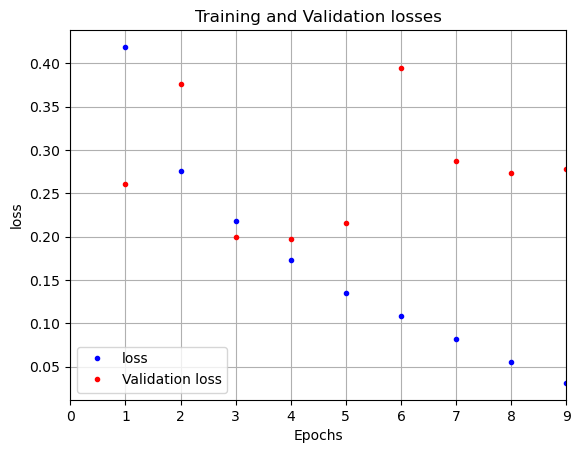

In [22]:
plot_training_history(wider_history, monitor='loss')

### Deeper Dense Layer Model

In [23]:
deeper = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

deeper.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 158, 158, 16)      160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 79, 79, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 99856)             0         
                                                                 
 dense_4 (Dense)             (None, 8)                 798856    
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                      

In [24]:
deeper.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [25]:
# Train the model
deeper_history = deeper.fit(x_train, y_train,
                                    batch_size=16,
                                    epochs=100, 
                                    validation_data=(x_val, y_val), 
                                    callbacks=[EARLY_STOP],
                                    verbose=0)

Restoring model weights from the end of the best epoch: 3.
Epoch 8: early stopping


In [26]:
# Evaluate the model on the test set
results = deeper.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.23160280287265778 - Accuracy: 0.935153603553772 - Precision: 0.9487804770469666 - Recall: 0.9581280946731567 - F1 Score: 0.9513831734657288 - AUC: 0.9600985646247864


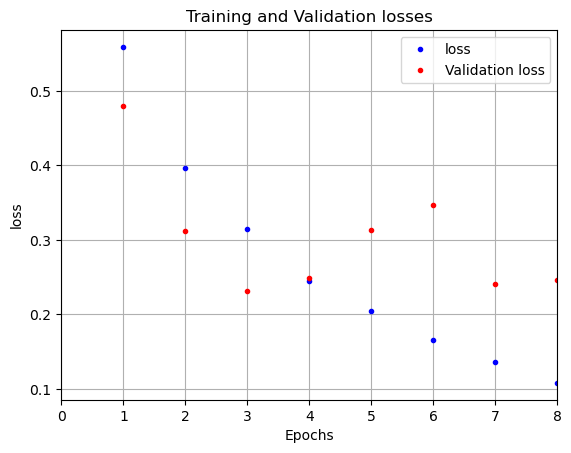

In [27]:
plot_training_history(deeper_history, monitor='loss')

### Deeper and Wider Dense Layer Model

In [28]:
deeper_wider = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

deeper_wider.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 158, 158, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 79, 79, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 99856)             0         
                                                                 
 dense_8 (Dense)             (None, 32)                3195424   
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                      

In [29]:
deeper_wider.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [30]:
# Train the model
deeper_wider_history = deeper_wider.fit(x_train, y_train,
                                    batch_size=16,
                                    epochs=100, 
                                    validation_data=(x_val, y_val), 
                                    callbacks=[EARLY_STOP],
                                    verbose=0)

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


In [31]:
# Evaluate the model on the test set
results = deeper_wider.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.20104314386844635 - Accuracy: 0.9334471225738525 - Precision: 0.9576059579849243 - Recall: 0.9458128213882446 - F1 Score: 0.9493474364280701 - AUC: 0.9690203070640564


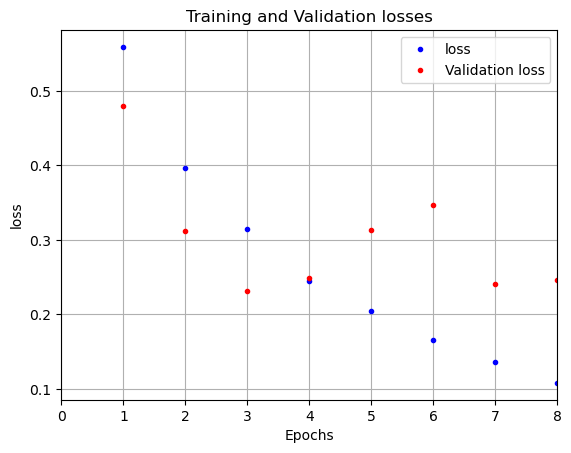

In [32]:
plot_training_history(deeper_history, monitor='loss')

### Deeper Convolutional Layers

In [33]:
# Define the CNN model
test1 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),   
    MaxPooling2D((2, 2)),
    
    # Second Convolution Block
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

test1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 158, 158, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 79, 79, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 77, 77, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 38, 38, 16)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 23104)             0         
                                                                 
 dense_12 (Dense)            (None, 8)                

In [34]:
test1.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [35]:
# Train the model
test1_history = test1.fit(x_train, y_train,
                                    batch_size=16,
                                    epochs=100, 
                                    validation_data=(x_val, y_val), 
                                    callbacks=[EARLY_STOP],
                                    verbose=0)

Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping


In [36]:
results = test1.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.22195549309253693 - Accuracy: 0.914675772190094 - Precision: 0.921800971031189 - Recall: 0.9581280946731567 - F1 Score: 0.9353740215301514 - AUC: 0.9662561416625977


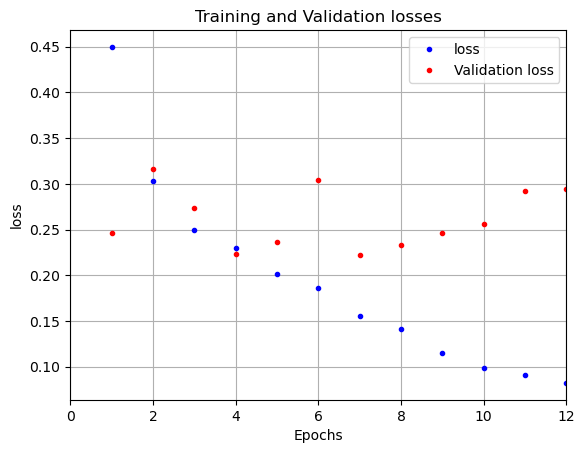

In [37]:
plot_training_history(test1_history, monitor='loss')

### Wider Convolutional Layers

In [38]:
# Define the CNN model
test2 = Sequential([

    Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    # Dense Layer
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid') 
])

test2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 158, 158, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 79, 79, 64)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 399424)            0         
                                                                 
 dense_14 (Dense)            (None, 8)                 3195400   
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,196,049
Trainable params: 3,196,049
Non-trainable params: 0
____________________________________________

In [39]:
test2.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [40]:
# Train the model
test2_history = test2.fit(x_train, y_train,
                                    batch_size=16,
                                    epochs=100, 
                                    validation_data=(x_val, y_val), 
                                    callbacks=[EARLY_STOP],
                                    verbose=0)

Restoring model weights from the end of the best epoch: 11.
Epoch 16: early stopping


In [41]:
results = test2.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.23630395531654358 - Accuracy: 0.92662113904953 - Precision: 0.9459459185600281 - Recall: 0.9482758641242981 - F1 Score: 0.9456063508987427 - AUC: 0.9553707838058472


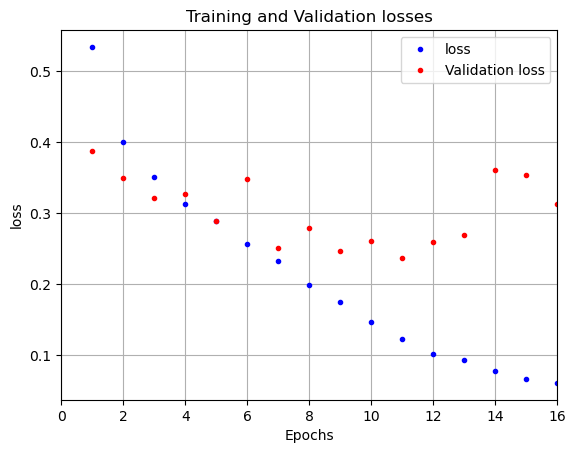

In [42]:
plot_training_history(test2_history, monitor='loss')

### Wider and Deeper Convolutional Layers

In [48]:
# Define the CNN model
test3 = Sequential([

    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),   
    MaxPooling2D((2, 2)),
    
    # Second Convolution Block
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    # Dense Layer
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid') 
])

test3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 158, 158, 16)      160       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 79, 79, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 77, 77, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 38, 38, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 18, 18, 64)      

In [49]:
test3.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [50]:
# Train the model
test3_history = test3.fit(x_train, y_train,
                                    batch_size=16,
                                    epochs=100, 
                                    validation_data=(x_val, y_val), 
                                    callbacks=[EARLY_STOP],
                                    verbose=0)

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


In [51]:
results = test3.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.17866386473178864 - Accuracy: 0.9368600845336914 - Precision: 0.9670885801315308 - Recall: 0.9408866763114929 - F1 Score: 0.95037442445755 - AUC: 0.9767240881919861


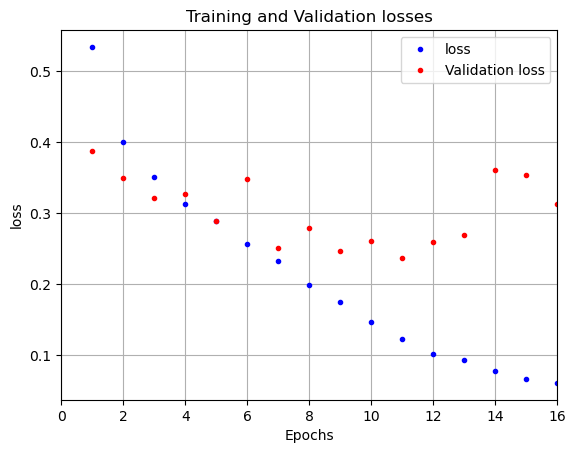

In [52]:
plot_training_history(test2_history, monitor='loss')

### Exploration Results and Suggestions


Best Performers: The deeper & wider model and deeper & wider convolutional layer model seem to consistently perform better across most metrics, including AUC. These models balance complexity and capacity well for our dataset.


Potential Overfitting: The deeper layer model shows diminishing returns, indicating possible overfitting without a significant gain in performance. Regularization (like dropout) might help when exploring deeper architectures.


Tuning Learning Rate: Fine-tune the learning rate. You might start with the Adam optimizer and test small learning rates (e.g., 1e-4, 1e-5).


Batch Size: Experiment with different batch sizes to find the optimal balance between training time and model performance.


Regularization: Add dropout layers to the models with more dense layers to prevent overfitting.


Epochs: Adjust the number of epochs and consider using early stopping to prevent overfitting while ensuring the model converges well.

Tuning Convolutional Layers: Performance of model is significantly impacted by the number of layers and filter size and should be tuned in the hyperparameter tuning process.

Tuning Dense Layers: For the models performing well (like the deeper and wider model), consider adding more filters or convolutional layers, but introduce regularization to avoid overfitting.


## 1.3 Hyperparameter Tuning

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2

def create_cnn_model(learning_rate=0.01, dropout_rate=0.2, add_dropout=True, activation='relu',
                     n_conv_layers=2, n_filters=[32, 64, 128, 256], filter_size=(3, 3), pool_size=(2, 2), 
                     n_dense_layers=1, n_neurons=[256, 128, 64, 32], l2_value=0.01,
                     optimizer_name='RMSprop'):
    
    clear_session()
    
    model = Sequential()
    model.add(Conv2D(n_filters[0], filter_size, activation=activation, input_shape=(img_height, img_width, 1)))
    model.add(MaxPooling2D(pool_size[0]))
    
    for i in range(1, n_conv_layers):
        model.add(Conv2D(n_filters[i] if i < len(n_filters) else n_filters[-1],
                         filter_size,
                         activation=activation))
        model.add(MaxPooling2D(pool_size))
    
    
    model.add(Flatten())
    
    for i in range(n_dense_layers):
        neurons = n_neurons[i] if i < len(n_neurons) else n_neurons[-1]
        model.add(Dense(neurons, activation=activation, kernel_regularizer=l2(l2_value)))
        if add_dropout:
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))

    # Dynamic optimizer selection based on optimizer_name
    if optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = KerasClassifier(build_fn=create_cnn_model, epochs=5, verbose=0)

param_grid = {
    'learning_rate': [ 0.01, 0.001, 0.0001 ],
    
    'add_dropout': [True, False],
    
    'dropout_rate': [ 0.2, 0.3 ], 
    
    'activation': [ 'relu', 'tanh' ], 
    
    'n_conv_layers': [ 1, 2, 3, 4 ],
    
    'n_filters': [ [64, 128, 256, 512] , [32, 64, 128, 256], [16, 32, 64, 128] ],
    
    'filter_size': [ (3, 3). (5, 5) ],
    
    'pool_size': [ (2, 2), (3, 3) ],
    
    'n_dense_layers': [ 2, 3, 4 ],
    
    'n_neurons':[ [512, 256, 128, 64], [256, 128, 64, 32], [128, 64, 32, 16] ],
    
    'l2_value':[ 0.1, 0.01, 0.001 ],
    
    'optimizer_name': [ 'Adam', 'RMSprop' ], 
    
    'batch_size': [ 32 ]
}


# Setup cross-validation using KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with n_jobs=1
grid = GridSearchCV(estimator=cnn_model, param_grid=param_grid, scoring='accuracy', n_jobs=1, cv=kfold)

print('fitting right now')

fitting right now


C:\Users\Yi Wei\AppData\Local\Temp\ipykernel_10032\1624139710.py:48: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cnn_model = KerasClassifier(build_fn=create_cnn_model, epochs=5, verbose=0)


In [54]:
grid_result = grid.fit(x_train, y_train)

30/30 [==============================] - 0s 3ms/step


In [55]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.906277 using {'activation': 'relu', 'add_dropout': True, 'batch_size': 32, 'dropout_rate': 0.2, 'filter_size': (3, 3), 'l2_value': 0.001, 'learning_rate': 0.001, 'n_conv_layers': 3, 'n_dense_layers': 2, 'n_filters': [32, 64, 128, 256], 'n_neurons': [256, 128, 64, 32], 'optimizer_name': 'Adam', 'pool_size': (2, 2)}


## 1.4 Final Training and Evaluation

In [56]:
optimal_cnn = create_cnn_model(learning_rate=0.001, dropout_rate=0.2, add_dropout=True, activation='relu',
                     n_conv_layers=3, n_filters=[32, 64, 128, 256], filter_size=(3, 3), pool_size=(2, 2), 
                     n_dense_layers=2, n_neurons=[256, 128, 64, 32], l2_value=0.001,
                     optimizer_name='Adam')

optimal_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [57]:
optimal_cnn.compile(optimizer=Adam(learning_rate=0.001), loss=LOSS_FUNC, metrics=METRICS)

In [58]:
# Train the model
optimal_cnn_history = optimal_cnn.fit(x_train, y_train,
                                    batch_size=32,
                                    epochs=100, 
                                    validation_data=(x_val, y_val), 
                                    callbacks=[EARLY_STOP],
                                    verbose=0)

Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping


In [59]:
results = optimal_cnn.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.23390991985797882 - Accuracy: 0.9505119323730469 - Precision: 0.9586374759674072 - Recall: 0.9704433679580688 - F1 Score: 0.9651458263397217 - AUC: 0.9773467779159546


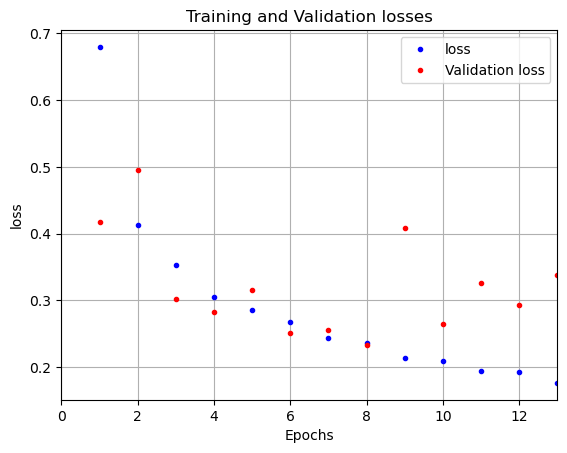

In [60]:
plot_training_history(optimal_cnn_history, monitor='loss')

## 1.5 Evaluate optimal CNN model on Test Data
Evaluation on Test Data:

Conducted comprehensive testing using the unseen test dataset to estimate real-world performance.

Recorded key metrics such as accuracy, F1 score, and AUC to assess model efficacy.

Compared test results with validation performance to confirm consistency and reliability.

Plot confusion matrics and ROC AUC curve to help visualise the results.

In [61]:
results = optimal_cnn.evaluate(x_test, y_test, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.20542046427726746 - Accuracy: 0.9556313753128052 - Precision: 0.9717646837234497 - Recall: 0.9672130942344666 - F1 Score: 0.970742404460907 - AUC: 0.9835401773452759


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, x_test, y_test, threshold=0.5):

    # Generate predictions on the test set
    y_pred_prob = model.predict(x_test)  # Predict probabilities
    y_pred = (y_pred_prob > threshold).astype(int)  # Convert probabilities to binary outcomes

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return cm

19/19 [==============================] - 0s 14ms/step


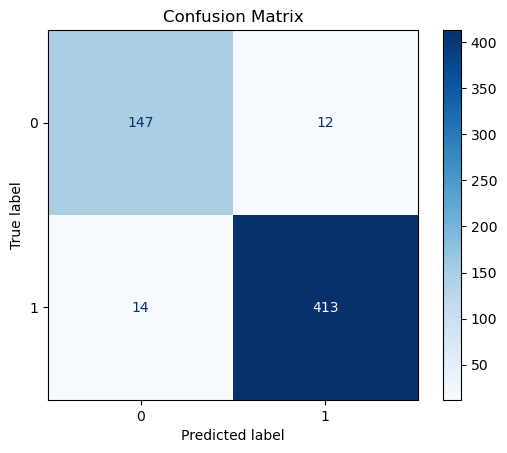

In [63]:
cm = plot_confusion_matrix(optimal_cnn, x_test, y_test, threshold=0.5)

#### Model Performance Insights:

High True Positives (TP): The model correctly predicted 413 positive cases, which is a strong indicator that the model is effective at identifying the positive class.

Low False Positives (FP): The model made 12 false positive predictions, indicating that the model doesn’t often misclassify negative instances as positive.

Low False Negatives (FN): The model made 14 false negative predictions, meaning that it missed 14 positive cases, which is relatively low.

True Negatives (TN): The model correctly identified 147 negative instances.

In [52]:
#from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, x_test, y_test):

    # Generate predicted probabilities on the test set
    y_pred_prob = optimal_cnn.predict(x_test)  # Get the predicted probabilities for the positive class

    # Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Calculate the AUC (Area Under the ROC Curve)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

19/19 [==============================] - 0s 7ms/step


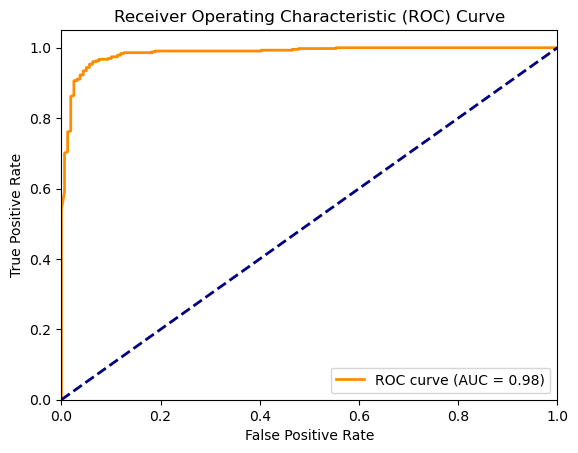

In [64]:
roc_auc = plot_roc_curve(optimal_cnn, x_test, y_test)

#### ROC-AUC Curve Observations

ROC Curve Shape: The curve is steep and closely follows the top-left corner, meaning the model maintains a high true positive rate (recall) while keeping false positives low.

Low False Positive Rate: The ROC curve indicates that the model achieves strong classification performance with very few false positives across different thresholds.

Conclusion: The model is performing exceptionally well and is highly reliable for binary classification tasks. Its performance metrics suggest that it is ready for deployment or further validation.

# 2. Dense Neural Network Model Explorations

## 2.1 Developing DNN Model That Does Better Than a Baseline 

In [13]:
# Define the model architecture
dnn_basemodel = Sequential([
    Flatten(input_shape=(img_height, img_width, 1), name="flatten"),
    Dense(8, activation="relu"),
    Dense(1, activation='sigmoid')
])

dnn_basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 8)                 204808    
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 204,817
Trainable params: 204,817
Non-trainable params: 0
_________________________________________________________________


In [14]:
dnn_basemodel.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [15]:
dnn_basemodel_history = dnn_basemodel.fit(x_train, y_train,
                                epochs=100,
                                batch_size=16,           
                                validation_data=(x_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping


In [16]:
results = dnn_basemodel.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.6165192127227783 - Accuracy: 0.6928327679634094 - Precision: 0.6928327679634094 - Recall: 1.0 - F1 Score: 0.8163890838623047 - AUC: 0.5027778148651123


## 2.2 Scaling Up and Exploration

### Wider Dense Layer Model

In [17]:
dnn_wider = Sequential(
    [
        Flatten(input_shape=(img_height, img_width, 1), name="flatten"),
        Dense(32, activation="relu", name="hidden"),
        Dense(1, activation="sigmoid", name="output")
    ],
)

dnn_wider.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 hidden (Dense)              (None, 32)                819232    
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 819,265
Trainable params: 819,265
Non-trainable params: 0
_________________________________________________________________


In [18]:
dnn_wider.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [19]:
dnn_wider_history = dnn_wider.fit(x_train, y_train,
                                epochs=100,
                                batch_size=16,           
                                validation_data=(x_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping


In [20]:
results = dnn_wider.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.286249041557312 - Accuracy: 0.8890784978866577 - Precision: 0.9108433723449707 - Recall: 0.931034505367279 - F1 Score: 0.920848548412323 - AUC: 0.9420976638793945


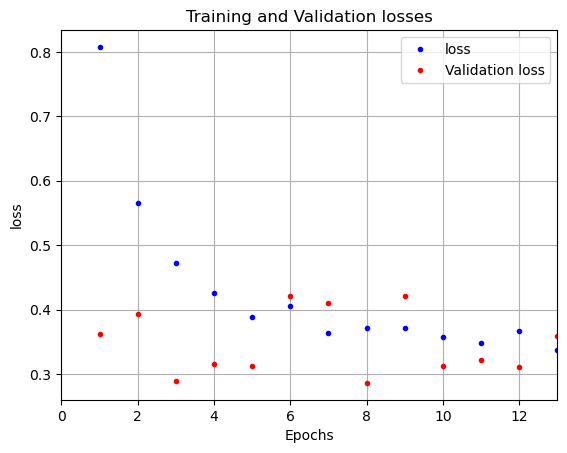

In [21]:
plot_training_history(dnn_wider_history, monitor='loss')

### Deeper Dense Layer Model

In [22]:
dnn_deeper = Sequential(
    [
        Flatten(input_shape=(img_height, img_width, 1), name="flatten"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(1, activation="sigmoid", name="output")
    ],
)

dnn_deeper.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense_2 (Dense)             (None, 8)                 204808    
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 204,961
Trainable params: 204,961
Non-trainable params: 0
_________________________________________________________________


In [23]:
dnn_deeper.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [24]:
dnn_deeper_history = dnn_wider.fit(x_train, y_train,
                                epochs=100,
                                batch_size=16,           
                                validation_data=(x_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

Restoring model weights from the end of the best epoch: 11.
Epoch 16: early stopping


In [25]:
results = dnn_deeper.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.6866850852966309 - Accuracy: 0.69112628698349 - Precision: 0.7881081104278564 - Recall: 0.8977832794189453 - F1 Score: 0.8147627115249634 - AUC: 0.7472342252731323


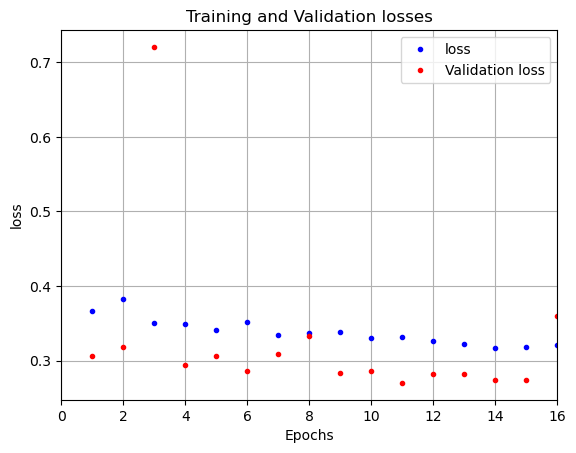

In [26]:
plot_training_history(dnn_deeper_history, monitor='loss')

### Deeper and Wider Dense Layer Model

In [27]:
dnn_deeper_wider = Sequential(
    [
        Flatten(input_shape=(img_height, img_width, 1), name="flatten"),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(8, activation="relu"),
        Dense(1, activation="sigmoid", name="output")
    ],
)

dnn_deeper_wider.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense_5 (Dense)             (None, 32)                819232    
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 819,905
Trainable params: 819,905
Non-trainable params: 0
_________________________________________________________________


In [28]:
dnn_deeper_wider.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [29]:
dnn_deeper_wider_history = dnn_deeper_wider.fit(x_train, y_train,
                                epochs=100,
                                batch_size=16,           
                                validation_data=(x_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

Restoring model weights from the end of the best epoch: 20.
Epoch 25: early stopping


In [30]:
results = dnn_deeper_wider.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.26277822256088257 - Accuracy: 0.8959044218063354 - Precision: 0.9116945266723633 - Recall: 0.9408866763114929 - F1 Score: 0.9263274669647217 - AUC: 0.9485427737236023


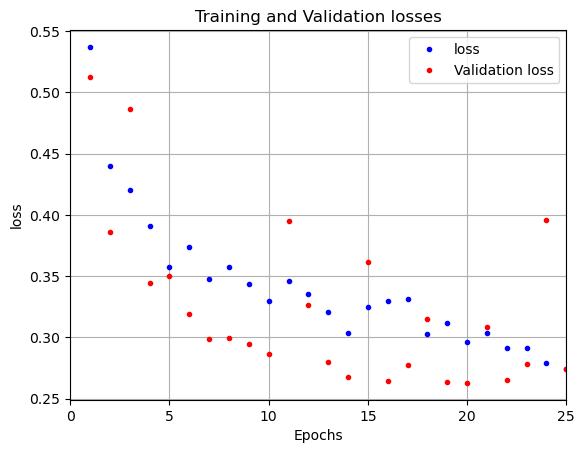

In [31]:
plot_training_history(dnn_deeper_wider_history, monitor='loss')

### Exploration Results and Suggestions for DNN Models

Best Performers:


Wider and Deeper & Wider Models: The dnn_wider and dnn_deeper_wider models consistently show strong performance across all metrics. Both models achieve high accuracy, F1 scores, and AUC values. These architectures demonstrate that increasing the model's capacity by adding more neurons and layers provides a significant boost in performance.



Deeper Model: The dnn_deeper model shows signs of overfitting. Despite having multiple layers, its performance metrics (accuracy, AUC) are lower than expected, indicating that the model might be overfitting to the training data without effectively generalizing to the test data. Consider adding regularization techniques like dropout to mitigate overfitting.


Tuning Learning Rate: Fine-tune the learning rate: As seen in the dnn_wider and dnn_deeper_wider models, smaller learning rates can improve convergence. Testing a smaller learning rate (e.g., 1e-4 or 1e-5) with optimizers like Adam could enhance these models further.


Regularization: Adding dropout layers, especially in the deeper and deeper & wider models, may help prevent overfitting. Dropout can be added after the hidden layers to ensure the model generalizes well to unseen data.


Tuning Dense Layers: In models like dnn_wider, consider adding more neurons to increase the model's capacity . However, ensure that regularization methods like dropout are implemented to prevent the model from memorizing the training data instead of learning meaningful patterns.


Tuning Activation Functions:Test Different Activation Functions: While ReLU works well, testing other activation functions like Leaky ReLU or ELU might provide better performance, especially in deeper architectures. These activations can prevent the vanishing gradient problem and improve convergence in deep networks.

## 2.3 Hyperparameter Tuning

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2
# Delete the above import after the project is completed

def create_dnn_model(learning_rate=0.001, dropout_rate=0.2, activation='relu', add_dropout=True,
                     n_layers=2, n_neurons=[1024, 512, 256, 128, 64], l2_value=0.001, add_l2_regularization=False, 
                     optimizer_name='Adam'):
    model = Sequential()
    
    model.add(Flatten(input_shape=(img_height, img_width, 1)))
    
    for i in range(n_layers):
        neurons = n_neurons[i] if i < len(n_neurons) else n_neurons[-1]

        if add_l2_regularization:
            model.add(Dense(neurons, activation=activation, kernel_regularizer=l2(l2_value)))
        else:
            model.add(Dense(neurons, activation=activation))
        
        if add_dropout:
            model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='sigmoid'))
    
    # Dynamic optimizer selection based on optimizer_name
    if optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

dnn_model = KerasClassifier(build_fn=create_dnn_model, epochs=5, verbose=0)

param_grid = {
    
    'learning_rate': [ 0.01, 0.001, 0.0001 ],
    
    'add_dropout': [True, False],
    
    'dropout_rate': [ 0.2, 0.3 ], 
    
    'activation': [ 'relu', 'tanh' ], 
    
    'n_layers': [ 1, 2, 3, 4, 5 ], 
    
    'n_neurons': [ [1024, 512, 256, 128, 64], [512, 256, 128, 64, 32], [256, 128, 64, 32, 16] ],
    
    'add_l2_regularization': [True, False],
    
    'l2_value':[ 0.1, 0.01, 0.001 ],
    
    'optimizer_name': [ 'Adam', 'RMSprop' ],
    
    'batch_size': [ 32 ]
}


# Setup cross-validation using KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with n_jobs=1
grid = GridSearchCV(estimator=dnn_model, param_grid=param_grid, scoring='accuracy', n_jobs=1, cv=kfold)

print('fitting right now')
# Fit model
grid_result = grid.fit(x_train, y_train)

fitting right now


C:\Users\Yi Wei\AppData\Local\Temp\ipykernel_16248\3000103237.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  dnn_model = KerasClassifier(build_fn=create_dnn_model, epochs=5, verbose=0)


30/30 [==============================] - 0s 2ms/step


In [39]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.823227 using {'activation': 'relu', 'add_dropout': True, 'add_l2_regularization': True, 'batch_size': 32, 'dropout_rate': 0.2, 'l2_value': 0.001, 'learning_rate': 0.001, 'n_layers': 1, 'n_neurons': [1024, 512, 256, 128, 64], 'optimizer_name': 'Adam'}


## 2.4 Final Model Training and Evaluation

In [40]:
optimal_dnn = create_dnn_model(learning_rate=0.001, dropout_rate=0.2, activation='relu', add_dropout=True,
                               n_layers=1, n_neurons=[1024, 512, 256, 128, 64], l2_value=0.001, 
                               add_l2_regularization=False, optimizer_name='Adam')

optimal_dnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 25600)             0         
                                                                 
 dense_22 (Dense)            (None, 1024)              26215424  
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                                 
 dense_23 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 26,216,449
Trainable params: 26,216,449
Non-trainable params: 0
_________________________________________________________________


In [41]:
optimal_dnn.compile(optimizer=Adam(learning_rate=0.001), loss=LOSS_FUNC, metrics=METRICS)

In [42]:
optimal_dnn_history = optimal_dnn.fit(x_train, y_train,
                                epochs=100,
                                batch_size=32,           
                                validation_data=(x_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

Restoring model weights from the end of the best epoch: 18.
Epoch 23: early stopping


In [43]:
results = optimal_dnn.evaluate(x_val, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.269069641828537 - Accuracy: 0.8976109027862549 - Precision: 0.9240196347236633 - Recall: 0.9285714030265808 - F1 Score: 0.9286257028579712 - AUC: 0.9519362449645996


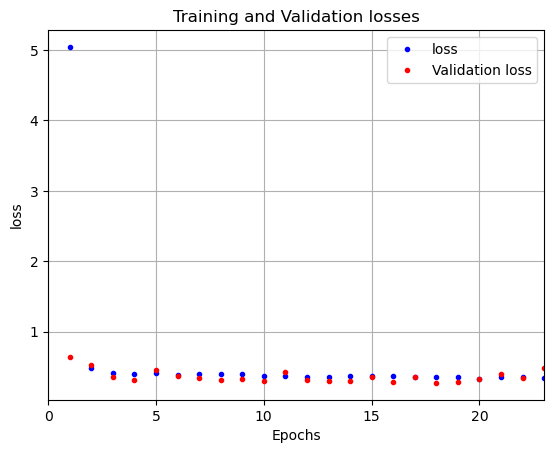

In [44]:
plot_training_history(optimal_dnn_history, monitor='loss')

#### Analysis:

Strong Overall Performance: The model shows strong performance across all key metrics. High precision, recall, F1 score, and AUC indicate that the model is well-balanced and capable of handling the binary classification task with high accuracy and discrimination ability.

Generalization: The relatively low loss (0.2691) combined with high accuracy and AUC suggests that the model generalizes well to the test data without significant overfitting.

Balanced Precision and Recall: The model maintains a good balance between precision and recall, as indicated by the similar values for both. This means the model is neither overly conservative.

Validation Loss Plot: The plot suggest that the model is well tuned with no overfitting and stability losses. 

In [45]:
results = optimal_dnn.evaluate(x_test, y_test, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.24339987337589264 - Accuracy: 0.9078498482704163 - Precision: 0.9429928660392761 - Recall: 0.9297423958778381 - F1 Score: 0.9382104277610779 - AUC: 0.9619621634483337


19/19 [==============================] - 0s 4ms/step


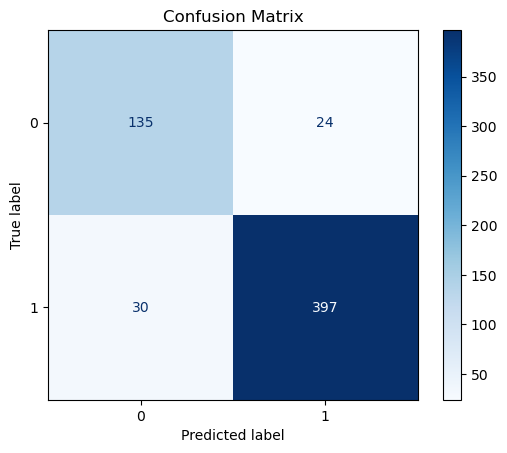

In [46]:
cm = plot_confusion_matrix(optimal_dnn, x_test, y_test, threshold=0.5)

#### Observations:

Strong True Positive Count (397): The model is highly successful at identifying positive cases, with a low false negative count of only 30, resulting in a high recall.

Moderate False Positive Count (24): While the false positive count is relatively low compared to true positives, there is still room for improvement in minimizing false positives. This would improve the precision further.

Strong True Negative Count (135): The model is effective at correctly identifying negative cases, successfully classifying 135 out of the total negative instances. This results in a good specificity of approximately 84.91%.

Moderate False Negative Count (30): The model incorrectly classifies 30 positive cases as negative, which slightly reduces the recall. However, the false negative count is relatively low, ensuring that the model captures most positive cases accurately.

Balanced Precision and Recall: The confusion matrix reflects the balance between precision and recall, as indicated by the F1 score (93.63%). The model performs well in correctly identifying both positive and negative cases with minimal errors.

19/19 [==============================] - 0s 2ms/step


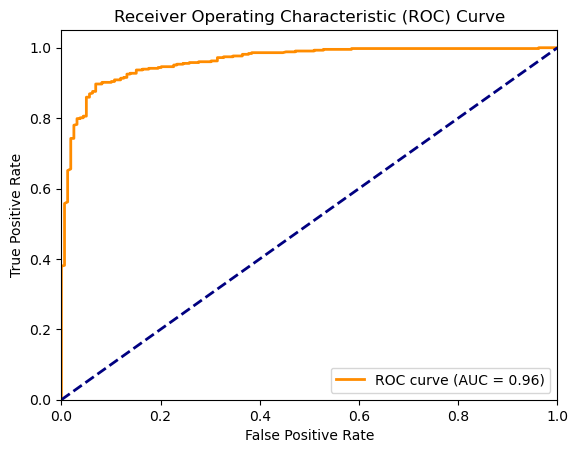

In [47]:
roc_auc = plot_roc_curve(optimal_dnn, x_test, y_test)

#### ROC-AUC Curve Observation

Steep Initial Rise: Indicates the model achieves a high true positive rate with few false positives early on.

Flattening at the Top: Suggests strong performance is maintained across various thresholds.

AUC of 0.96: Reflects excellent discriminative power, showing the model effectively distinguishes between positive and negative classes.

# 3. Support Vector Machine(SVM) Model Exploration

## 3.1 Developing SVM Model That Does Better Than a Baseline

In [45]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Flatten the image data
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)

In [46]:
# Train your SVM model
svm_model = SVC(kernel='linear', probability=True)  # Make sure probability=True for AUC calculation
svm_model.fit(x_train_flat, y_train)

# Make predictions
y_pred = svm_model.predict(x_val_flat)
y_pred_prob = svm_model.predict_proba(x_val_flat)[:, 1]  # For AUC calculation

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_prob)

# Print the results
print(f"Validation results - Accuracy: {accuracy} - Precision: {precision} - Recall: {recall} - F1 Score: {f1} - AUC: {auc}")

Validation results - Accuracy: 0.8344709897610921 - Precision: 0.8814814814814815 - Recall: 0.8793103448275862 - F1 Score: 0.8803945745992602 - AUC: 0.8930487137383689


## 3.2 SVM Hyperparameter Tuning

In [47]:
# Define the hyperparameter grid
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],       
    'gamma': ['scale', 0.001, 0.1, 1]  
}

# Set up KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV instance with KFold cross-validation
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=kfold, scoring='accuracy', n_jobs=1, verbose=0)

# Fit the grid search to the data
grid_search.fit(x_train_flat, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


## 3.3 Final Model Training and Evaluation¶

In [48]:
# Evaluate on the test set
x_test_flat = x_test.reshape(x_test.shape[0], -1)

y_test_pred = best_svm_model.predict(x_test_flat)
y_test_prob = best_svm_model.predict_proba(x_test_flat)[:, 1]  # For AUC score

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_prob)

# Print the results
print(f"Test results - Accuracy: {accuracy} - Precision: {precision} - Recall: {recall} - F1 Score: {f1} - AUC: {auc}")

Test results - Accuracy: 0.9334470989761092 - Precision: 0.9511627906976744 - Recall: 0.9578454332552693 - F1 Score: 0.9544924154025671 - AUC: 0.9793056721606057


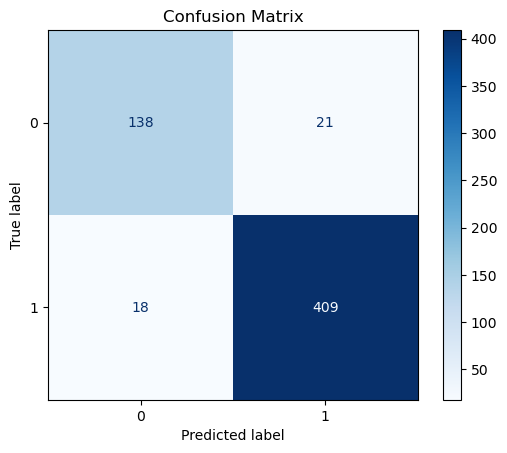

In [54]:
cm = plot_confusion_matrix(best_svm_model, x_test, y_test_pred, threshold=0.5)

#### Observations

Strong Performance: The model has a high number of true positives (409) and true negatives (138), showing that it performs well at identifying both classes.

Moderate False Positives: There are 21 false positives, which indicates that the model is slightly prone to predicting some negative cases as positive.

Low False Negatives: There are 18 false negatives, meaning that the model misses fewer actual positive cases, contributing to a good recall.

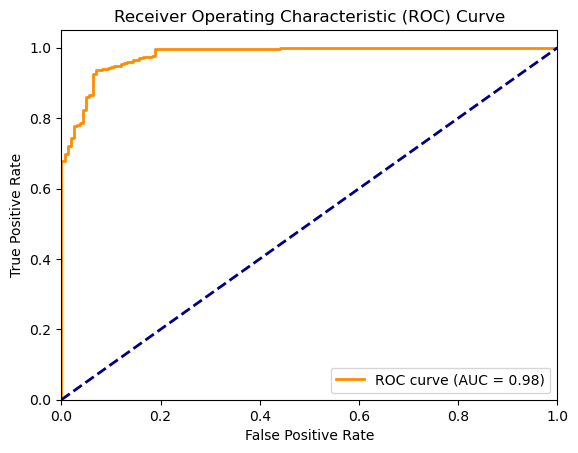

In [64]:
plot_roc_curve(best_svm_model, x_test, y_test_prob)

#### Observations from the ROC-AUC Curve

Steep Initial Rise: The ROC curve shows a steep rise, indicating that the model achieves a high true positive rate (TPR) with a relatively low false positive rate (FPR) at the beginning. This is a sign that the model is making confident and correct predictions for many cases.

High AUC Score (0.98): An AUC score of 0.98 indicates excellent model performance. The closer the AUC score is to 1.0, the better the model is at distinguishing between positive and negative classes. Your model has a very high discriminatory power.

Low False Positive Rate: The curve remains close to the y-axis for most of the range, which indicates a low false positive rate. The model makes very few false positive errors as the threshold changes.

# 4. Long Short Term Memory Neural Network Model Explorations

## 4.1 Developing LSTM Model That Does Better Than a Baseline 

In [43]:
# Reshape the image data
x_train_lstm = x_train.reshape(-1, img_height, img_width)  # Reshape to (batch_size, 160, 160)
x_val_lstm = x_val.reshape(-1, img_height, img_width)

In [44]:
# Define the model architecture
lstm_basemodel = Sequential([
    LSTM(32, input_shape=(img_height, img_width), return_sequences=False),
    Dense(8, activation="relu"),
    Dense(1, activation='sigmoid')
])

lstm_basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                24704     
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 24,977
Trainable params: 24,977
Non-trainable params: 0
_________________________________________________________________


In [45]:
lstm_basemodel.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [46]:
lstm_basemodel_history = lstm_basemodel.fit(x_train_lstm, y_train,
                                epochs=100,
                                batch_size=16,           
                                validation_data=(x_val_lstm, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

Restoring model weights from the end of the best epoch: 44.
Epoch 49: early stopping


In [47]:
results = lstm_basemodel.evaluate(x_val_lstm, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.3776613771915436 - Accuracy: 0.841296911239624 - Precision: 0.8789346218109131 - Recall: 0.8940886855125427 - F1 Score: 0.8884284496307373 - AUC: 0.8943691849708557


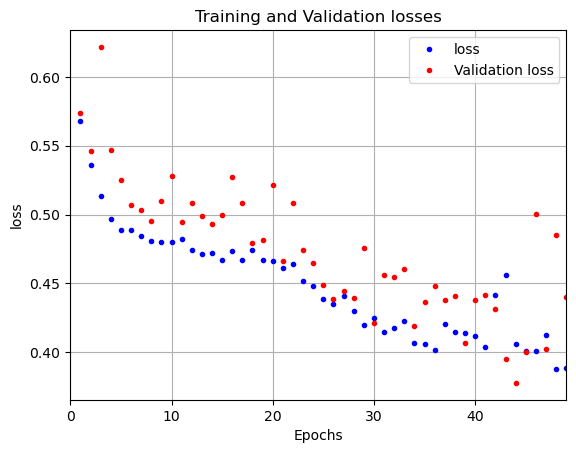

In [48]:
plot_training_history(lstm_basemodel_history, monitor='loss')

## 4.2 Scaling Up and Exploration

### Deeper Dense Layer Model

In [49]:
# Define the model architecture
deeper = Sequential([
    LSTM(32, input_shape=(img_height, img_width), return_sequences=False),
    Dense(32, activation="relu"),
    Dense(1, activation='sigmoid')
])

deeper.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                24704     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 25,793
Trainable params: 25,793
Non-trainable params: 0
_________________________________________________________________


In [50]:
deeper.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [51]:
deeper_history = deeper.fit(x_train_lstm, y_train,
                                epochs=100,
                                batch_size=16,           
                                validation_data=(x_val_lstm, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

Restoring model weights from the end of the best epoch: 15.
Epoch 20: early stopping


In [52]:
results = deeper.evaluate(x_val_lstm, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.4721646308898926 - Accuracy: 0.7457337975502014 - Precision: 0.7787418365478516 - Recall: 0.8842364549636841 - F1 Score: 0.8255852460861206 - AUC: 0.8115695118904114


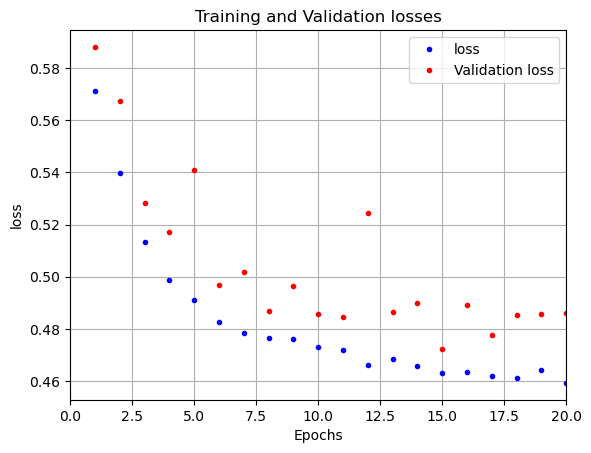

In [53]:
plot_training_history(deeper_history, monitor='loss')

### Wider Dense Layer Model

In [54]:
# Define the model architecture
wider = Sequential([
    LSTM(32, input_shape=(img_height, img_width), return_sequences=False),
    Dense(8, activation="relu"),
    Dense(8, activation="relu"),
    Dense(8, activation="relu"),
    Dense(1, activation='sigmoid')
])

wider.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                24704     
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25,121
Trainable params: 25,121
Non-trainable params: 0
_________________________________________________________________


In [55]:
wider.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [56]:
wider_history = wider.fit(x_train_lstm, y_train,
                                epochs=100,
                                batch_size=16,           
                                validation_data=(x_val_lstm, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

Restoring model weights from the end of the best epoch: 17.
Epoch 22: early stopping


In [57]:
results = wider.evaluate(x_val_lstm, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.4790497422218323 - Accuracy: 0.7320818901062012 - Precision: 0.7643312215805054 - Recall: 0.8866994976997375 - F1 Score: 0.8185315728187561 - AUC: 0.8107759356498718


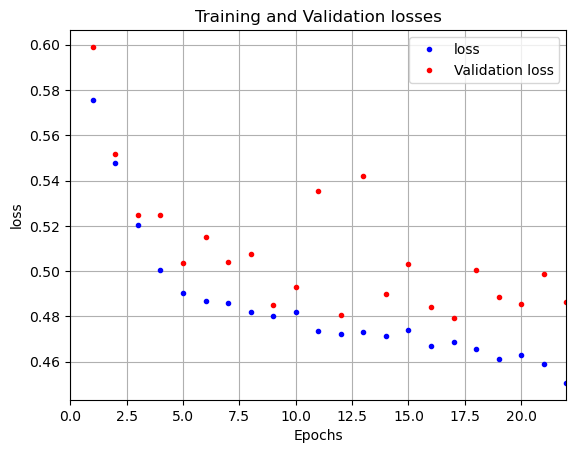

In [58]:
plot_training_history(wider_history, monitor='loss')

### Deeper and Wider Dense Layer Model

In [59]:
# Define the model architecture
deeper_wider = Sequential([
    LSTM(32, input_shape=(img_height, img_width), return_sequences=False),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(1, activation='sigmoid')
])

deeper_wider.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                24704     
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 26,433
Trainable params: 26,433
Non-trainable params: 0
_________________________________________________________________


In [60]:
deeper_wider.compile(optimizer=Adam(learning_rate=learning_rate), loss=LOSS_FUNC, metrics=METRICS)

In [61]:
deeper_wider_history = deeper_wider.fit(x_train_lstm, y_train,
                                epochs=100,
                                batch_size=16,           
                                validation_data=(x_val_lstm, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

Restoring model weights from the end of the best epoch: 30.
Epoch 35: early stopping


In [62]:
results = deeper_wider.evaluate(x_val_lstm, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.32082870602607727 - Accuracy: 0.8771331310272217 - Precision: 0.8938679099082947 - Recall: 0.9334975481033325 - F1 Score: 0.9129778146743774 - AUC: 0.9244664311408997


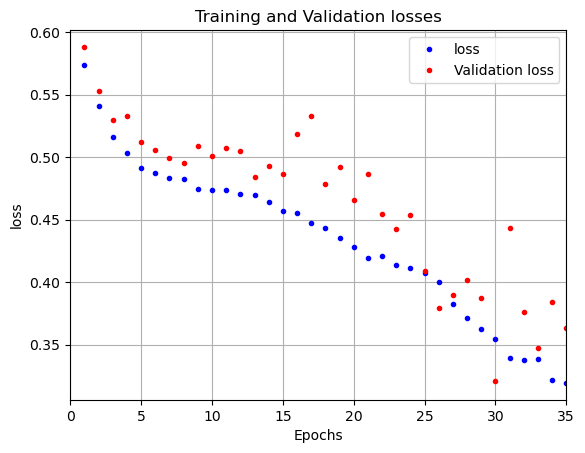

In [63]:
plot_training_history(deeper_wider_history, monitor='loss')

### Exploration Results and Suggestions for LSTM Models


Best Performers:Deeper & Wider Model: The deeper_wider model stands out with the best overall performance across all metrics, particularly in accuracy (87.71%), F1 score (91.30%), and AUC (0.92). This indicates that adding more layers and neurons helped the model capture more complex patterns in the data, leading to better performance.


Potential Overfitting: The wider model, despite having multiple layers and neurons, shows lower performance across most metrics compared to the basemodel. With an AUC of 0.81 and accuracy of 73.2%, it may be overfitting to the training data or struggling with generalization due to its complexity. Adding regularization like dropout could help reduce overfitting.


Tuning Learning Rate: For Hyperparameter tuning, testing smaller learning rates with the different optimizer could lead to even better performance and more stable convergence.


Batch Size:Experiment with Batch Sizes: The larger models (like deeper_wider) may benefit from smaller batch sizes to improve generalization. Exploring a range of batch sizes (e.g., 16, 32) might help find the optimal configuration.


Regularization: Introducing dropout or L2 regularization layers after LSTM or dense layers, especially in the deeper and wider models, can help reduce overfitting.


Tuning LSTM Layers: In the basemodel and deeper_wider models, experimenting with the number of units (e.g., 64, 128) in the LSTM layers could lead to better performance. More units can allow the LSTM to capture more temporal dependencies in the image data.


Tuning Dense Layers: The deeper_wider model’s success suggests that increasing layer depth works, but should be combined with regularization techniques like dropout and L2 regularization. Exploring different configurations of neurons and activation functions could lead to even better results.

## 4.3 Hyperparameter Tuning

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2
# Delete the above import after the project is completed

def create_lstm_model(learning_rate=0.001, dropout_rate=0.2, activation='relu', add_dropout=True,
                      n_lstm_layers=2, n_lstm_units=[64, 32], l2_value=0.001, add_l2=True,
                      n_layers=1, n_neurons=[64, 32], optimizer_name='Adam'):
    
    model = Sequential()
    # Adding LSTM layers
    for i in range(n_lstm_layers):
        units = n_lstm_units[i] if i < len(n_lstm_units) else n_lstm_units[-1]
        
        if i == 0:  # First LSTM layer with input shape
            if add_l2:
                model.add(LSTM(units, input_shape=(img_height, img_width), return_sequences=(i < n_lstm_layers - 1),
                               kernel_regularizer=l2(l2_value)))
            else:
                model.add(LSTM(units, input_shape=(img_height, img_width), return_sequences=(i < n_lstm_layers - 1)))
                
        else:  # Subsequent LSTM layers
            if add_l2_regularization:
                model.add(LSTM(units, return_sequences=(i < n_lstm_layers - 1), kernel_regularizer=l2(l2_value)))
                
            else:
                model.add(LSTM(units, return_sequences=(i < n_lstm_layers - 1)))
            
    for i in range(n_layers):
        neurons = n_neurons[i] if i < len(n_neurons) else n_neurons[-1]

        model.add(Dense(neurons, activation=activation))
        
        if add_dropout:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    # Dynamic optimizer selection based on optimizer_name
    if optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_model = KerasClassifier(build_fn=create_lstm_model, epochs=5, verbose=0)

param_grid = {
    'learning_rate': [ 0.01, 0.001, 0.0001 ],   

    'add_dropout': [ True, False ],  
    
    'dropout_rate': [ 0.2, 0.3 ],  
    
    'activation': [ 'relu', 'tanh' ], 

    'n_lstm_layers': [ 1, 2 3 ],

    'n_lstm_units': [ [512, 256, 128], [256, 128, 64], [128, 64, 32] ],
    
    'add_l2': [ True, False ],  

    'l2_value': [ 0.001, 0.0001 ],        

    'n_layers': [ 1, 2, 3 ], 
    
    'n_neurons': [ [512, 256, 128, 64], [256, 128, 64, 32], [128, 64, 32, 16], [64, 32, 16, 8]  ],
    
    'optimizer_name': ['Adam', 'RMSprop' ],
    
    'batch_size': [ 32 ]
}

# Setup cross-validation using KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with n_jobs=1
grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, scoring='accuracy', n_jobs=1, cv=kfold)

print('fitting right now')
# Fit model
grid_result = grid.fit(x_train_lstm, y_train)

fitting right now


C:\Users\Yi Wei\AppData\Local\Temp\ipykernel_25980\2405599659.py:57: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasClassifier(build_fn=create_lstm_model, epochs=5, verbose=0)


30/30 [==============================] - 0s 5ms/step


In [65]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.735694 using {'activation': 'relu', 'add_dropout': True, 'add_l2': False, 'batch_size': 32, 'dropout_rate': 0.2, 'l2_value': 0.0001, 'learning_rate': 0.001, 'n_layers': 3, 'n_lstm_layers': 1, 'n_lstm_units': [512, 256], 'n_neurons': [128, 64, 32], 'optimizer_name': 'Adam'}


## 4.4 Final Model Training and Evaluation

In [66]:
optimal_lstm = create_lstm_model(learning_rate=0.001, dropout_rate=0.2, activation='relu', add_dropout=True,
                      n_lstm_layers=1, n_lstm_units=[512, 256], l2_value=0.0001, add_l2=False,
                      n_layers=3, n_neurons=[128, 64, 32], optimizer_name='Adam')

optimal_lstm.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 512)               1378304   
                                                                 
 dense_86 (Dense)            (None, 128)               65664     
                                                                 
 dropout_53 (Dropout)        (None, 128)               0         
                                                                 
 dense_87 (Dense)            (None, 64)                8256      
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 dense_88 (Dense)            (None, 32)                2080      
                                                                 
 dropout_55 (Dropout)        (None, 32)              

In [67]:
optimal_lstm.compile(optimizer=Adam(learning_rate=0.001), loss=LOSS_FUNC, metrics=METRICS)

In [68]:
optimal_lstm_history = optimal_lstm.fit(x_train_lstm, y_train,
                                epochs=100,
                                batch_size=32,           
                                validation_data=(x_val_lstm, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

Restoring model weights from the end of the best epoch: 22.
Epoch 27: early stopping


In [69]:
results = optimal_lstm.evaluate(x_val_lstm, y_val, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.3088753819465637 - Accuracy: 0.8805460929870605 - Precision: 0.9117646813392639 - Recall: 0.9162561297416687 - F1 Score: 0.9133079648017883 - AUC: 0.9300493001937866


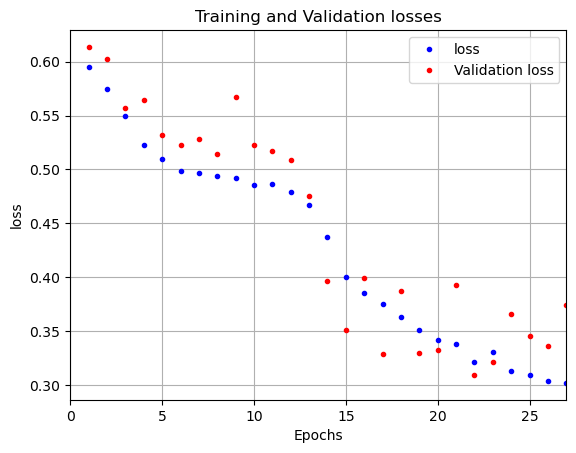

In [70]:
plot_training_history(optimal_lstm_history, monitor='loss')

In [71]:
x_test_lstm = x_test.reshape(-1, img_height, img_width)

results = optimal_lstm.evaluate(x_test_lstm, y_test, verbose=0)
print(f'Test results - Loss: {results[0]} - Accuracy: {results[1]} - Precision: {results[2]} - Recall: {results[3]} - F1 Score: {results[4]} - AUC: {results[5]}')

Test results - Loss: 0.31125763058662415 - Accuracy: 0.8907849788665771 - Precision: 0.9172413945198059 - Recall: 0.9344262480735779 - F1 Score: 0.9243212342262268 - AUC: 0.931428849697113


19/19 [==============================] - 0s 15ms/step


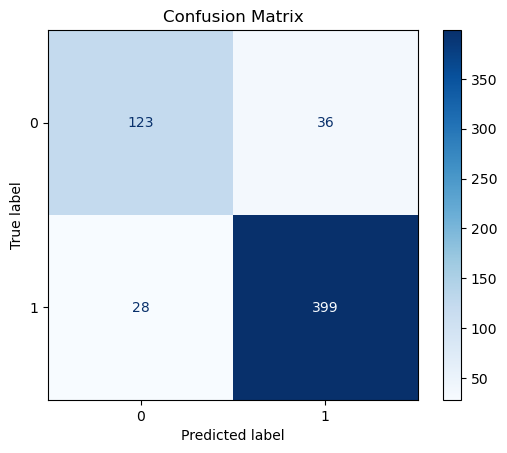

In [72]:
cm = plot_confusion_matrix(optimal_lstm, x_test, y_test, threshold=0.5)

#### Observations

Strong True Positive Count (399): The model is highly effective at correctly classifying positive cases, which contributes to a high recall.

Moderate False Positive Count (36): The false positive count suggests that the model occasionally misclassifies negative instances as positive. This might affect the model's precision.

Moderate False Negative Count (28): The false negative count indicates that some positive cases are missed by the model, which could slightly impact recall.

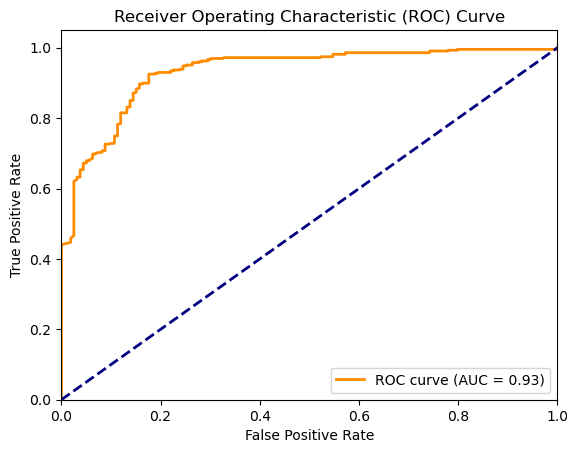

In [73]:
roc_auc = plot_roc_curve(optimal_lstm, x_test, y_test)

#### Observations from the ROC-AUC Curve

Initial Rise: The curve shows a steep initial rise, which is a positive sign that the model achieves a high true positive rate (TPR) with a relatively low false positive rate (FPR) early on. This suggests that the model makes good predictions with high confidence for many samples.

Moderate Curve Flattening: After the initial steep rise, the curve starts to flatten, indicating that as the decision threshold lowers, the model's performance slightly drops. This flattening suggests that the model's predictions are less confident as it tries to capture more positive cases, leading to a higher FPR.

Potential for Improvement: There is some flattening in the curve, suggesting the model could be refined to reduce the false positive rate and further improve its discriminative power.

# 5 Conclusion

## 5.1 Overall Observations

CNN is the best performer across all metrics. It excels at spatial feature extraction, which gives it an edge in image classification tasks.

SVM also performs strongly, showing competitive accuracy, precision, recall, and AUC. It is a viable alternative to CNN for image classification.

DNN is a solid model but lags behind CNN and SVM, likely due to its inability to handle spatial dependencies as effectively.

LSTM is the least suited for this task, which makes sense given that LSTMs are designed for sequential data rather than spatial data like images.

## 5.2 Determining Factor of Metrics

In the context of our image classification project, both AUC and accuracy are critical metrics that provide different insights into the model's performance, and each has specific relevance to our use cases.


### Accuracy

Accuracy measures the overall proportion of correct predictions out of the total predictions. It gives a straightforward view of how well the model performs in classifying both positive and negative cases.

In our case, high accuracy is essential because it reflects the model's ability to correctly classify the majority of images, which is a key goal in any image classification task. For instance, the CNN model achieves a remarkable 95.56% accuracy, showing that it correctly identifies most images, whether they belong to the positive or negative class.


### AUC (Area Under the ROC Curve)

AUC assesses how well the model differentiates between classes at different threshold levels, emphasizing the balance between the true positive rate and the false positive rate.

High AUC is especially valuable in scenarios where you want to ensure that the model effectively separates positive and negative classes, regardless of the classification threshold. For example, with an AUC of 0.98, both the CNN and SVM models demonstrate excellent class separation, meaning that they are highly effective at distinguishing between positive and negative images.

Since the dataset is imbalanced, AUC can help assess whether the model is effectively distinguishing between the minority and majority classes, which are Normal and Pneumonia respectively. A poor AUC for the minority class could indicate that the model is biased towards the majority class and isn't performing well on the minority class.


## 5.3 Comparative Analysis

### AUC curve Analysis

<b> AUC-ROC Curve </b>
<p></p>
  
<div style="display: flex;">
    CNN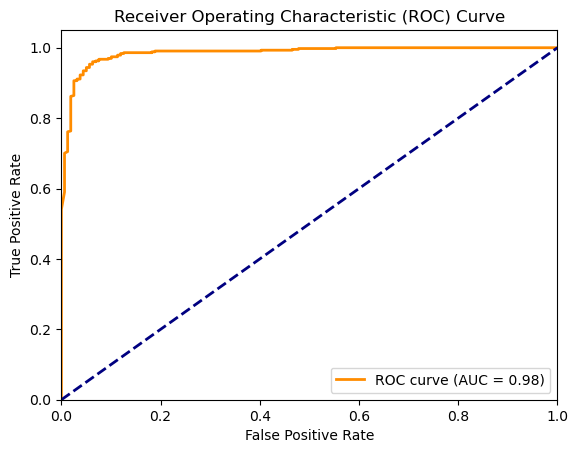 
    DNN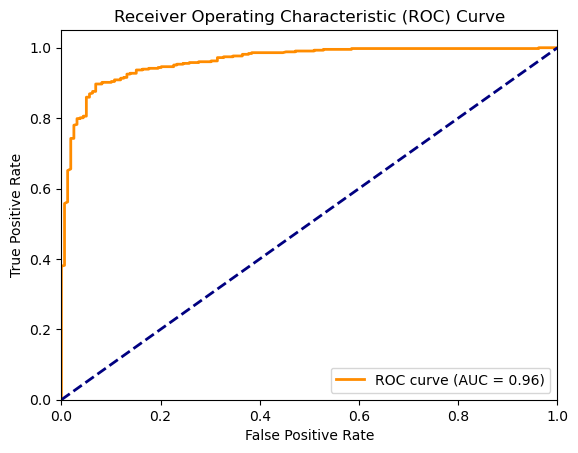 
</div>

<div style="display: flex;">
    SVM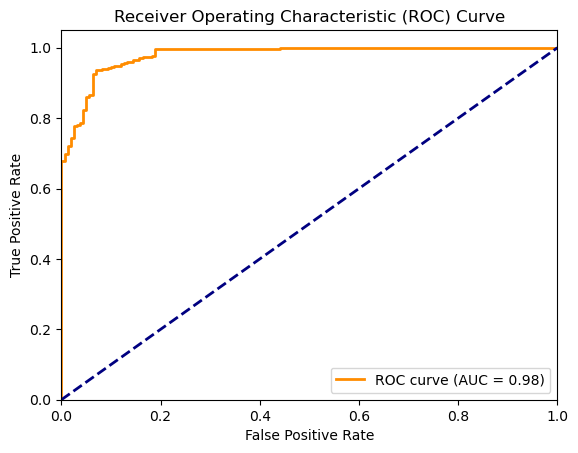 
    LSTM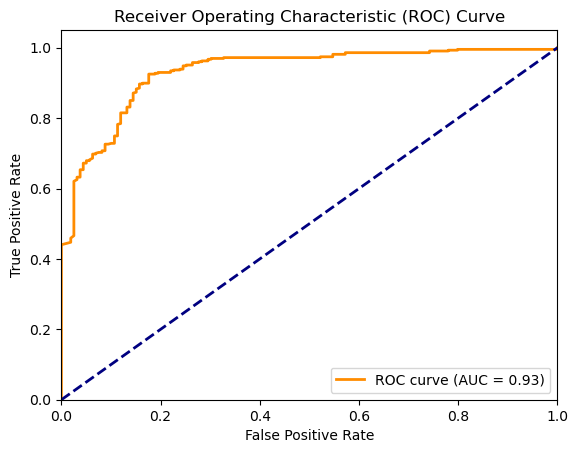 
</div>

CNN and SVM: Both exhibit excellent performance with AUC scores of 0.98, indicating their strong capability in classifying the dataset accurately.

DNN: Performs slightly below CNN and SVM with an AUC of 0.96, still indicating strong classification ability.

LSTM: While achieving a respectable AUC of 0.93, it underperforms compared to the other models, likely due to its architectural design being more suited to sequence modeling rather than image classification.


## 5.4 Recommendation 

For image classification of chest x-ray pneumonia, CNN is the best option followed closely by SVM. Both models are effective in seperating classes but are computational intensive to run on.

If computational resources are limited, DNN would be the better pick here as it less complex and simplier to design.

Lastly, LSTM would not be suitable in our usecase as it has the lowest performance metrics across all models tested while being more computational intensive than DNN.